#Mask detection 

First we import the libraries that we will need:

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')
!ls -a ./drive/My\ Drive/Colab\ Notebooks/yolo/images/train

## Prepare Train Data:

We first read file names:

In [ ]:
images = os.path.join("./drive/My Drive/Colab Notebooks/yolo/images")
labels = os.path.join("./drive/My Drive/Colab Notebooks/yolo/labels")
train_images = os.listdir(images + "/train")
train_labels = os.listdir(labels + "/train")
train_images.sort()
train_labels.sort()

In [ ]:
f = open("./drive/My Drive/Colab Notebooks/yolo/labels/train/" + train_labels[0], "r+")

In [ ]:
f.read()

'1 0.523976 0.620614 0.561404 0.574561\n'

In [ ]:
# TODO: construct dataframe with annotations 
data_ls = []
for train_label, train_image in tqdm(zip(train_labels, train_images)):
    f = open("./drive/My Drive/Colab Notebooks/yolo/labels/train/" + train_label, "r+")
    data_ls.append([train_label] + [train_image] + [float(x) for x in (f.read().replace("\n", "")).split(" ")])

Some of the images has more than one box.
Here we want to do image classification as opposed to sentiment segmentation, therefore we filter out images that have more than one box:

In [ ]:
data_ls_onebox = list(filter(lambda x: len(x) == 7, data_ls))
print(len(data_ls_onebox))

684


Next we make a pandas dataframe out of data_ls_onebox, and do a little bit of operations on the dataframe:

In [ ]:
train = pd.DataFrame(data_ls_onebox, columns = ['labelname', 'imagename', 'classname', 'x1', 'x2', 'y1', 'y2']) # Make a dataframe
train = train[['labelname', 'imagename', 'x1', 'x2', 'y1', 'y2', 'classname']] # Re-order the columns
train.classname = train.classname.astype(int) # Change the classname column to integer type
print(pd.unique(train.classname))
train.classname = train.classname.apply(lambda x: 'face_with_mask' if x == 0 else 'face_no_mask') # Change the classname column to face_with_mask and face_no_mask
print(pd.unique(train.classname))
train.sort_values(by='labelname', axis=0, inplace=True) # Sort rows by the value in the "name" column

[1 0]
['face_no_mask' 'face_with_mask']


Example Training Image


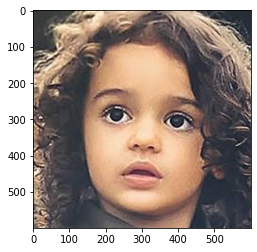

In [ ]:
print("Example Training Image")
img = plt.imread(os.path.join(images, "train", train_images[2]))
plt.imshow(img)
plt.show()

In [ ]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
#Preserve aspect ratio?
img_size = 50
data = []
def create_data():
       for [labelname, imagename, classname, x1, x2, y1, y2] in tqdm(data_ls_onebox):
            path_to_label = os.path.join(labels, "train", labelname)
            path_to_image = os.path.join(images, "train", imagename)
            img_array = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE) # reads in the image and converts it to greyscale
            # crops the image to only include the face
            # crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            # print("crop_image =", crop_image)
            new_img_array = cv2.resize(img_array, (img_size, img_size)) # resizes the image to 50x50
            data.append([new_img_array, int(classname)])
create_data() 

In [ ]:
data[0]

[array([[ 78,  68,  87, ...,  89,  80,  74],
        [194, 130, 193, ..., 160, 124, 119],
        [ 87,  56,  91, ...,  86,  91,  86],
        ...,
        [157, 220, 230, ...,  13,  15,  29],
        [157, 227, 231, ...,  12,  13,  16],
        [153, 230, 233, ...,  11,  19,  17]], dtype=uint8), 1]

In [ ]:
data[0][1]

1

In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

my_x = [data[_][0] for _ in range(len(data))]
my_y = [data[_][1] for _ in range(len(data))]

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)
tensor_y = tensor_y.type(torch.LongTensor)

my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
trainloader = DataLoader(my_dataset, batch_size=64, shuffle=True) # create your dataloader

## Prepare Test Data

In [ ]:
images = os.path.join("./drive/My Drive/Colab Notebooks/yolo/images")
annotations = os.path.join("./drive/My Drive/Colab Notebooks/yolo/labels")
a_test = os.listdir(images+"/valid")
b_test = os.listdir(annotations+"/valid")
a_test.sort()
b_test.sort()
test_images = a_test
test_lables = b_test

In [ ]:
# TODO: construct dataframe with annotations 
data_ls = []
for i in tqdm(range(min(len(test_images), len(test_lables)))):
    f = open("./drive/My Drive/Colab Notebooks/yolo/labels/valid/"+test_lables[i],"r+")
    data_ls.append(([test_lables[i].split("/")[-1]]+
                    [float(x) for x in (f.read().replace("\n","")).split(" ")]))

In [ ]:
#Some images have more than one box, here we only select the photos with one box
data_ls_onebox = []
print("data_ls =", data_ls)
print(len(data_ls))
for i in range(min(len(test_images), len(test_lables))):
  if len(data_ls[i]) == 6:
    data_ls_onebox.append(data_ls[i])
print("data_ls_onebox =", data_ls_onebox)
print(len(data_ls_onebox))

data_ls = [['0.txt', 1.0, 0.572954, 0.635233, 0.630117, 0.612573], ['100.txt', 1.0, 0.49693, 0.628655, 0.615497, 0.616959], ['103.txt', 1.0, 0.51959, 0.732455, 0.491228, 0.447368], ['107.txt', 1.0, 0.457457, 0.716374, 0.612573, 0.538012], ['108.txt', 1.0, 0.491814, 0.64693, 0.681287, 0.592105], ['11.txt', 1.0, 0.50424, 0.676901, 0.682749, 0.526316], ['116.txt', 1.0, 0.509356, 0.69883, 0.459064, 0.511696], ['118.txt', 1.0, 0.55614, 0.652047, 0.532164, 0.54386], ['121.txt', 1.0, 0.499123, 0.579678, 0.678363, 0.609649], ['127.txt', 1.0, 0.529093, 0.573831, 0.773392, 0.688596], ['128.txt', 1.0, 0.466959, 0.567982, 0.730994, 0.729532], ['129.txt', 1.0, 0.491082, 0.624268, 0.437135, 0.552632], ['131.txt', 1.0, 0.48889, 0.615497, 0.508772, 0.587719], ['133.txt', 1.0, 0.480848, 0.649123, 0.583333, 0.608187], ['136.txt', 1.0, 0.468422, 0.684941, 0.611111, 0.592105], ['139.txt', 1.0, 0.472808, 0.688597, 0.5, 0.561404], ['14.txt', 1.0, 0.490351, 0.623539, 0.640351, 0.656433], ['144.txt', 1.0, 0.4

In [ ]:
test = pd.DataFrame(data_ls_onebox, columns = ["name",'classname','x1','x2','y1','y2'])
test = test[["name",'x1','x2','y1','y2','classname']]
test.classname = test.classname.astype(int)

def convert_class_name(x):
    # 1 indicates no mask
    # 0 indicates mask
    if x == 1:
        return 'face_no_mask'
    if x == 0:
        return 'face_with_mask'

test.classname = test.classname.apply(lambda x: convert_class_name(x))

In [ ]:
options = ['face_with_mask', 'face_no_mask']
test = test[test['classname'].isin(options)] # TODO: removes other options, may not want to do this because removes some feature data that could be useful
test.sort_values('name', axis=0, inplace=True)

display(test)

Example Test Image


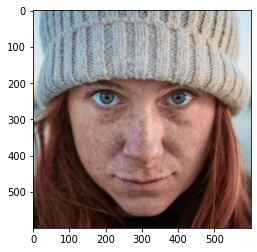

In [ ]:
print("Example Test Image")
images = os.path.join("./drive/My Drive/Colab Notebooks/yolo/images")
testimages_path = images + "/valid"
img = plt.imread(os.path.join(testimages_path, test_images[2]))
plt.imshow(img)
plt.show()

In [ ]:
# Extracts images and places the information into a list (data) of 50x50 pixel images
#Preserve aspect ratio?
img_size = 50
data = []
def create_data():
       for i in tqdm(range(len(test))):
            # arr=[]
            # for j in train.iloc[i]:
            #        arr.append(j)
            # print("arr =", arr)
            # reads in the image and converts it to greyscale
            path = os.path.join(images, "valid")
            path_to_label = os.path.join(path, test.iloc[i]["name"])
            path_to_image = os.path.join(testimages_path, test_images[i])
            # print("path to label =", path_to_label)
            # print("path to image =", path_to_image)
            # img=plt.imread(path_to_image)
            # plt.imshow(img)
            # plt.show()
            img_array = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
            # crops the image to only include the face
            # crop_image = img_array[arr[2]:arr[4],arr[1]:arr[3]]
            # print("crop_image =", crop_image)
            # resizes the image to 50x50
            new_img_array = cv2.resize(img_array, (img_size, img_size))
            data.append([new_img_array, test.iloc[i]["classname"]])
create_data() 

In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

my_x = [data[_][0] for _ in range(len(data))]
my_y = [int(1) if data[_][1] == "face_no_mask" else int(0) for _ in range(len(data))]

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)
tensor_y = tensor_y.type(torch.LongTensor)

my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
testloader = DataLoader(my_dataset, batch_size=1, shuffle=False) # create your dataloader

## Model Building:

In [ ]:
for images, labels in trainloader:
  print("images =", images)
  print("labels =", labels)
  break

In [ ]:
# Build a feed-forward network
from torch import nn
model = nn.Sequential(nn.Linear(2500, 1024),
                      nn.Tanh(),
                      nn.Linear(1024, 512),
                      nn.Tanh(),
                      nn.Linear(512, 64),
                      nn.Tanh(),
                      nn.Linear(64, 2),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

epochs = 4000
losses = []
for e in tqdm(range(epochs)):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 2500 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    losses.append(running_loss/len(trainloader))

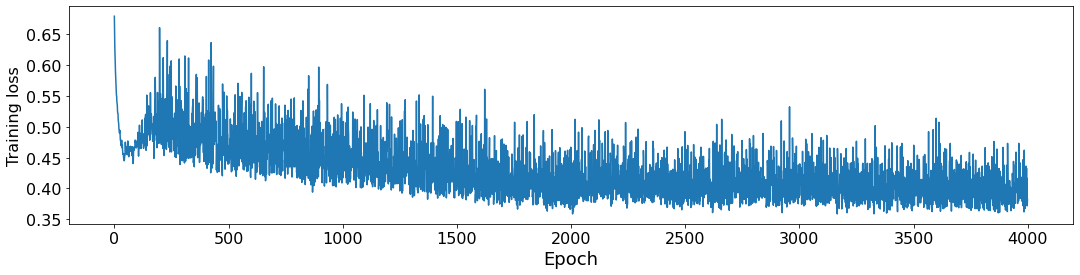

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 4), ncols=1)
ax.plot(losses)
ax.set_ylabel("Training loss", size=16)
ax.set_xlabel("Epoch", size=18)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
fig.show()
fig.savefig('./drive/My Drive/Colab Notebooks/'+"loss.png",dpi=300,bbox_inches="tight",transparent=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    plt.tight_layout()
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), ncols=2)
    ax1.imshow(img.resize_(1, 50, 50).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(["face_mask", "face_no_mask"])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    return fig

labels = tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])
ps = tensor([[0.9341, 0.0659]])


<Figure size 432x288 with 0 Axes>

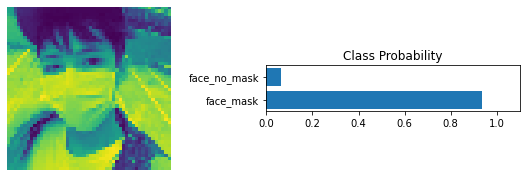

In [ ]:
%matplotlib inline
#images, labels = next(iter(trainloader))
for index, (images, labels) in enumerate(trainloader):
  if index == 2:
    print("labels =", labels)
    break
img = images[0].view(1, 2500)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
print("ps =", ps)
fig = view_classify(img.view(1, 50, 50), ps)
fig.show()

In [ ]:
y_train = []
pred_train = []
for images, labels in trainloader:
  for i in range(len(labels)):
    y_train.append(labels[i])
    with torch.no_grad():
      logps = model(images[i].view(1, 2500))
      pred_train.append(torch.exp(logps).numpy().argmax())
print("len(y_train) =", len(y_train))
print("len(pred_train) =", len(pred_train))

len(y_train) = 684
len(pred_train) = 684


In [ ]:
# This cell does not run on its own, it is just a trick to make the fonts larger without having those crossing lines
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import matplotlib

def plot_confusion_matrix2(true_values, prediction_values):
  matplotlib.rcParams['font.sans-serif'] = "Arial" # set default font to Arial
  matplotlib.rcParams['font.family'] = "sans-serif" # ALWAYS use sans-serif fonts
  matplotlib.rcParams['font.size'] = 16
  fig, ax = plt.subplots()
  cm = confusion_matrix(true_values, prediction_values)
  tn, fp, fn, tp = cm.ravel()
  print("TN:",tn, " FP:", fp, " FN:", fn, " TP:", tp)
  sns.set(font_scale=1.0) #edited as suggested
  #sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  # annot=True to annotate cells
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mask", "No Mask"])
  disp.plot(cmap='GnBu', ax=ax)
  title = 'Mask Detection Model'
  ax.set_title("Densenet121")
  fig.show()
  fig.savefig('./drive/My Drive/Colab Notebooks/'+"confusion_matrix.pdf",dpi=300,bbox_inches="tight",transparent=True)

plot_confusion_matrix2(y_train, pred_train)

TN: 205  FP: 114  FN: 14  TP: 351


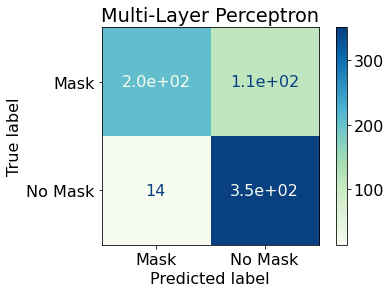

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
    
cm = confusion_matrix(y_train, pred_train)
tn, fp, fn, tp = cm.ravel()
print("TN:",tn," FP:",fp," FN:",fn," TP:",tp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mask","No Mask"])
disp.plot(cmap='GnBu',ax=ax)
ax.set_title("Multi-Layer Perceptron")
fig.show()
fig.savefig('./drive/My Drive/Colab Notebooks/'+"confusion_matrix.png",dpi=300,bbox_inches="tight",transparent=True)

In [ ]:
y_test = []
pred_test = []
for images, labels in testloader:
  for i in range(len(labels)):
    y_test.append(labels[i])
    with torch.no_grad():
      logps = model(images[i].view(1, 2500))
      pred_test.append(torch.exp(logps).numpy().argmax())
print("len(y_test) =", len(y_test))
print("len(pred_test) =", len(pred_test))

len(y_test) = 233
len(pred_test) = 233


TN: 65  FP: 49  FN: 8  TP: 111


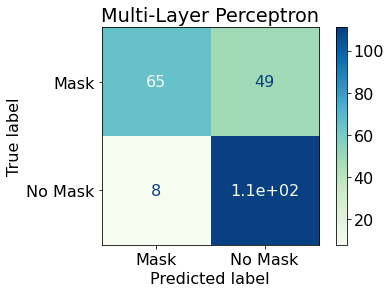

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
    
cm = confusion_matrix(y_test, pred_test)
tn, fp, fn, tp = cm.ravel()
print("TN:",tn," FP:",fp," FN:",fn," TP:",tp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mask","No Mask"])
disp.plot(cmap='GnBu',ax=ax)
ax.set_title("Multi-Layer Perceptron")
fig.show()
fig.savefig('./drive/My Drive/Colab Notebooks/'+"confusion_matrix.png",dpi=300,bbox_inches="tight",transparent=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.89      0.57      0.70       114
           1       0.69      0.93      0.80       119

    accuracy                           0.76       233
   macro avg       0.79      0.75      0.75       233
weighted avg       0.79      0.76      0.75       233

